In [1]:
# Core packages
import scanpy as sc
import pandas as pd
from pathlib import Path
import numpy as np
import scipy.sparse as sp
import pyranges as pr
from tqdm import tqdm
import anndata as ad
import matplotlib.pyplot as plt
import os
import scvi
import time
from fancyimpute import SoftImpute
import torch
import torch.nn as nn
import torch.optim as optim

device = 'cuda' if torch.cuda.is_available() else 'cpu'

/home/xetrin/miniconda3/envs/rna_atac_env/lib/python3.10/site-packages/sorted_nearest/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/home/xetrin/miniconda3/envs/rna_atac_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load RNA metadata
rna_meta  = pd.read_csv(
    r"/mnt/e/Projects/Brain/Data/SEAAD/SEAAD_MTG_RNAseq_all-nuclei_metadata.2024-02-13.csv",
    dtype={"sample_id": str},       # keep any leading zeros, etc.
    index_col="sample_id"           # like rownames() in R
)
rna_meta["sample_id"] = rna_meta.index
# Print shape
print(f"Total rows: {rna_meta.shape[0]}")
print(f"Total columns: {rna_meta.shape[1]}")

for col in rna_meta.columns:
    print(col)

print(f"Total donors: {rna_meta['Donor ID'].nunique(dropna=False)}")

# Detect and print tables for factor-like columns
print("\nFrequency tables for categorical columns:")
for col in rna_meta.columns:
    num_unique = rna_meta[col].nunique(dropna=False)
    if num_unique < 20:
        print(f"\nColumn: {col} ({num_unique} levels)")
        print(rna_meta[col].value_counts(dropna=False))

Total rows: 1957283
Total columns: 136
exp_component_name
Neurotypical reference
Donor ID
Organism
Brain Region
Sex
Gender
Age at Death
Race (choice=White)
Race (choice=Black/ African American)
Race (choice=Asian)
Race (choice=American Indian/ Alaska Native)
Race (choice=Native Hawaiian or Pacific Islander)
Race (choice=Unknown or unreported)
Race (choice=Other)
specify other race
Hispanic/Latino
Highest level of education
Years of education
PMI
Fresh Brain Weight
Brain pH
Overall AD neuropathological Change
Thal
Braak
CERAD score
Overall CAA Score
Highest Lewy Body Disease
Total Microinfarcts (not observed grossly)
Total microinfarcts in screening sections
Atherosclerosis
Arteriolosclerosis
LATE
Cognitive Status
Last CASI Score
Interval from last CASI in months
Last MMSE Score
Interval from last MMSE in months
Last MOCA Score
Interval from last MOCA in months
APOE Genotype
Primary Study Name
Secondary Study Name
NeuN positive fraction on FANS
RIN
cell_prep_type
facs_population_plan
rn

In [3]:
# Load ATAC metadata
atac_meta = pd.read_csv(
    r"/mnt/e/Projects/Brain/Data/SEAAD/SEAAD_MTG_ATACseq_all-nuclei_metadata.2024-12-06.csv",
    dtype={"sample_id": str},
    index_col="sample_id"
)
atac_meta["sample_id"] = atac_meta.index
# Print shape
print(f"Total rows: {atac_meta.shape[0]}")
print(f"Total columns: {atac_meta.shape[1]}")

for col in atac_meta.columns:
    print(col)

print(f"Total donors: {atac_meta['Donor ID'].nunique(dropna=False)}")

# Detect and print tables for factor-like columns
print("\nFrequency tables for categorical columns:")
for col in atac_meta.columns:
    num_unique = atac_meta[col].nunique(dropna=False)
    if num_unique < 20:
        print(f"\nColumn: {col} ({num_unique} levels)")
        print(atac_meta[col].value_counts(dropna=False))

Total rows: 1123761
Total columns: 130
index
Neurotypical reference
Donor ID
Organism
Brain Region
Sex
Gender
Age at Death
Race (choice=White)
Race (choice=Black/ African American)
Race (choice=Asian)
Race (choice=American Indian/ Alaska Native)
Race (choice=Native Hawaiian or Pacific Islander)
Race (choice=Unknown or unreported)
Race (choice=Other)
specify other race
Hispanic/Latino
Highest level of education
Years of education
PMI
Fresh Brain Weight
Brain pH
Overall AD neuropathological Change
Thal
Braak
CERAD score
Overall CAA Score
Highest Lewy Body Disease
Total Microinfarcts (not observed grossly)
Total microinfarcts in screening sections
Atherosclerosis
Arteriolosclerosis
LATE
Cognitive Status
Last CASI Score
Interval from last CASI in months
Last MMSE Score
Interval from last MMSE in months
Last MOCA Score
Interval from last MOCA in months
APOE Genotype
Primary Study Name
Secondary Study Name
cell_prep_type
facs_population_plan
rna_amplification
sample_name
sample_quantity_coun

In [4]:
# Find shared columns
common_cols = rna_meta.columns.intersection(atac_meta.columns)

# Remove shared columns from ATAC metadata
clean_atac_meta = atac_meta.drop(columns=common_cols)

print(clean_atac_meta)

# Merge metadata on sample_id (outer join, equivalent to full_join in R)
merged_meta = rna_meta.join(
    clean_atac_meta, how="inner"    # like dplyr::inner_join on rownames
)

# Filter to sample_ids present in both datasets
common_samples = rna_meta.index.intersection(atac_meta["sample_id"])
merged_meta = merged_meta[merged_meta["sample_id"].isin(common_samples)]

# Copy Donor.ID to donor_id
merged_meta["donor_id"] = merged_meta["Donor ID"]

# Save merged metadata to CSV
out_path = (r"/mnt/e/Projects/Brain/Data/SEAAD/SEAAD_MTG_Multiome_all-nuclei_merged_metadata.csv")
merged_meta.to_csv(out_path, index=True)


                                                                                         index  \
sample_id                                                                                        
CTTCTAACACAAGGGT-L8AT_211215_01_G07-1149773124  CTTCTAACACAAGGGT-L8AT_211215_01_G07-1149773124   
TGTAAAGCACATTAAC-L8XR_210805_01_H09-1124629228  TGTAAAGCACATTAAC-L8XR_210805_01_H09-1124629228   
TAGACTGCATCCTGGG-L8AT_210916_01_B08-1131409693  TAGACTGCATCCTGGG-L8AT_210916_01_B08-1131409693   
CGTTGCAAGTCTATGA-L8XR_210805_01_H09-1124629228  CGTTGCAAGTCTATGA-L8XR_210805_01_H09-1124629228   
CCGTGAGTCGTCCCAT-L8AT_211011_01_B01-1136687632  CCGTGAGTCGTCCCAT-L8AT_211011_01_B01-1136687632   
...                                                                                        ...   
TTACTTGGTGCCCTAG-L8AT_220112_01_A04-1155512003  TTACTTGGTGCCCTAG-L8AT_220112_01_A04-1155512003   
GCCTTGCGTGGTGAGA-L8XR_210722_01_H07-1122543705  GCCTTGCGTGGTGAGA-L8XR_210722_01_H07-1122543705   
TTGAGCACACTGAAGG-L8A

In [5]:
# Define input file paths
metadata_file = Path("/mnt/e/Projects/Brain/Data/SEAAD/SEAAD_MTG_Multiome_all-nuclei_merged_metadata.csv")
rna_data_dir = Path("/mnt/e/Projects/Brain/Data/SEAAD/donor_data/RNA/")
rna_outfile = Path("/mnt/e/Projects/Brain/SEA_AD_analysis/results/aggregated_multiomic/aggregated_rna_data.h5ad")
atac_data_dir = Path("/mnt/e/Projects/Brain/Data/SEAAD/donor_data/ATAC/")
atac_outfile = Path("/mnt/e/Projects/Brain/SEA_AD_analysis/results/aggregated_multiomic/aggregated_genelevel_atac_data.h5ad")

# Load metadata containing donor/sample mappings
metadata = pd.read_csv(metadata_file)

# Get list of unique donor IDs with multiomic data
multiomic_donors = metadata["donor_id"].unique()
print(multiomic_donors)


['H20.33.013' 'H20.33.002' 'H20.33.005' 'H20.33.039' 'H21.33.006'
 'H20.33.008' 'H20.33.018' 'H21.33.008' 'H20.33.014' 'H20.33.020'
 'H21.33.003' 'H20.33.025' 'H20.33.015' 'H20.33.016' 'H20.33.001'
 'H20.33.004' 'H20.33.044' 'H21.33.001' 'H20.33.038' 'H20.33.011'
 'H20.33.012' 'H21.33.019' 'H20.33.040' 'H20.33.043' 'H20.33.027'
 'H20.33.017' 'H20.33.019' 'H20.33.028']


In [6]:
rna_list = []

for donor_id in metadata["donor_id"].unique():
    donor_samples = metadata.query("donor_id == @donor_id")["sample_id"].unique()

    # Find matching RNA file
    rna_file = next(rna_data_dir.glob(f"*{donor_id}*.h5ad"), None)
    if not rna_file:
        print(f"No RNA file found for donor {donor_id}")
        continue

    print(f"Loading RNA for donor {donor_id}")
    adata = sc.read_h5ad(rna_file)

    # Subset to relevant samples
    if "sample_id" in adata.obs.columns:
        adata = adata[adata.obs["sample_id"].isin(donor_samples)].copy()
    else:
        print(f"No 'sample_id' column in RNA obs for donor {donor_id}, skipping.")
        continue

    # Add donor label
    adata.obs["donor_id"] = donor_id

    rna_list.append(adata)
    del adata  # free memory

# Concatenate all donor RNA
aggregated_rna = sc.concat(rna_list, join="outer", index_unique=None)
aggregated_rna.write(rna_outfile, compression=None)
del rna_list, aggregated_rna


Loading RNA for donor H20.33.013
Loading RNA for donor H20.33.002
Loading RNA for donor H20.33.005
Loading RNA for donor H20.33.039
Loading RNA for donor H21.33.006
Loading RNA for donor H20.33.008
Loading RNA for donor H20.33.018
Loading RNA for donor H21.33.008
Loading RNA for donor H20.33.014
Loading RNA for donor H20.33.020
Loading RNA for donor H21.33.003
Loading RNA for donor H20.33.025
Loading RNA for donor H20.33.015
Loading RNA for donor H20.33.016
Loading RNA for donor H20.33.001
Loading RNA for donor H20.33.004
Loading RNA for donor H20.33.044
Loading RNA for donor H21.33.001
Loading RNA for donor H20.33.038
Loading RNA for donor H20.33.011
Loading RNA for donor H20.33.012
Loading RNA for donor H21.33.019
Loading RNA for donor H20.33.040
Loading RNA for donor H20.33.043
Loading RNA for donor H20.33.027
Loading RNA for donor H20.33.017
Loading RNA for donor H20.33.019
Loading RNA for donor H20.33.028


In [7]:
# Load gene annotations once
genes_df = pd.read_csv("/mnt/e/Projects/Brain/Data/SEAAD/gene_annotations_buffered_5kb.bed", sep="\t", names=["Chromosome", "Start", "End", "Gene"])
genes = pd.Series(genes_df["Gene"].dropna().unique())
gene_to_index = {gene: i for i, gene in enumerate(genes)}

# Pre-construct gene PyRanges
genes_pr = pr.PyRanges(genes_df)

atac_list = []

for donor_id in metadata["donor_id"].unique():
    donor_samples = metadata.query("donor_id == @donor_id")["sample_id"].unique()

    # Find matching ATAC file
    atac_file = next(atac_data_dir.glob(f"*{donor_id}*.h5ad"), None)
    if not atac_file:
        print(f"No ATAC file found for donor {donor_id}")
        continue

    print(f"Loading ATAC for donor {donor_id}")
    atac = sc.read_h5ad(atac_file)

    # Subset to relevant samples
    if "sample_id" in atac.obs.columns:
        atac = atac[atac.obs["sample_id"].isin(donor_samples)].copy()
    else:
        print(f"No 'sample_id' column in ATAC obs for donor {donor_id}, skipping.")
        continue

    atac.obs["donor_id"] = donor_id

    # Normalize and log1p
    #sc.pp.normalize_total(atac, target_sum=1e4)
    #sc.pp.log1p(rna)

    # Extract peak coordinates
    peak_coords = atac.var.index.to_series().str.extract(r"(chr[\w]+):(\d+)-(\d+)")
    peak_coords.columns = ["Chromosome", "Start", "End"]
    peak_coords["Start"] = peak_coords["Start"].astype(int)
    peak_coords["End"] = peak_coords["End"].astype(int)
    peak_coords["peak_id"] = np.arange(len(peak_coords))

    peaks_pr = pr.PyRanges(peak_coords)

    # Map peaks to nearest gene
    peak_to_gene = peaks_pr.nearest(genes_pr).df
    n_peaks = atac.shape[1]

    # Filter valid mappings
    valid_rows = peak_to_gene[
        peak_to_gene["Gene"].isin(gene_to_index) &
        peak_to_gene["peak_id"].notnull() &
        (peak_to_gene["peak_id"] < n_peaks)
    ].copy()

    valid_rows["gene_idx"] = valid_rows["Gene"].map(gene_to_index)
    valid_rows["peak_idx"] = valid_rows["peak_id"].astype(int)

    rows = valid_rows["peak_idx"].values
    cols = valid_rows["gene_idx"].values
    data = np.ones(len(rows), dtype=np.uint8)
    peak_gene_map = sp.csr_matrix((data, (rows, cols)), shape=(n_peaks, len(genes)))

    # Batch matrix multiplication
    atac_X = atac.X.tocsr()
    peak_gene_map_csc = peak_gene_map.tocsc()
    peak_counts_per_gene = np.array(peak_gene_map_csc.sum(axis=0)).flatten()
    peak_counts_per_gene[peak_counts_per_gene == 0] = 1
    norm_diag = sp.diags(1 / peak_counts_per_gene)

    batch_size = 5000
    n_cells = atac_X.shape[0]
    result_chunks = []

    print(f"Projecting ATAC to genes for donor {donor_id}...")
    for start in tqdm(range(0, n_cells, batch_size)):
        end = min(start + batch_size, n_cells)
        batch = atac_X[start:end, :]
        chunk = batch @ peak_gene_map_csc
        chunk = chunk @ norm_diag
        result_chunks.append(chunk)

    access_mat = sp.vstack(result_chunks)

    # Create new AnnData object with gene-level accessibility
    atac_gene = ad.AnnData(X=access_mat, obs=atac.obs.copy())
    atac_gene.var_names = genes
    atac_gene.var_names_make_unique()

    # Append to list
    atac_list.append(atac_gene)

    # Free memory
    del atac, atac_gene, access_mat, result_chunks

# Final aggregation
print("Concatenating gene-level donor AnnData objects...")
aggregated_atac = sc.concat(atac_list, join="outer", index_unique=None)
aggregated_atac.write(atac_outfile, compression=None)

del atac_list, aggregated_atac

Loading ATAC for donor H20.33.013
Projecting ATAC to genes for donor H20.33.013...


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.57s/it]


Loading ATAC for donor H20.33.002
Projecting ATAC to genes for donor H20.33.002...


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.19it/s]


Loading ATAC for donor H20.33.005
Projecting ATAC to genes for donor H20.33.005...


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.06s/it]


Loading ATAC for donor H20.33.039
Projecting ATAC to genes for donor H20.33.039...


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.25s/it]


Loading ATAC for donor H21.33.006
Projecting ATAC to genes for donor H21.33.006...


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.37s/it]


Loading ATAC for donor H20.33.008
Projecting ATAC to genes for donor H20.33.008...


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.03s/it]


Loading ATAC for donor H20.33.018
Projecting ATAC to genes for donor H20.33.018...


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.19it/s]


Loading ATAC for donor H21.33.008
Projecting ATAC to genes for donor H21.33.008...


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.03it/s]


Loading ATAC for donor H20.33.014
Projecting ATAC to genes for donor H20.33.014...


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.05s/it]


Loading ATAC for donor H20.33.020
Projecting ATAC to genes for donor H20.33.020...


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.41s/it]


Loading ATAC for donor H21.33.003
Projecting ATAC to genes for donor H21.33.003...


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.11it/s]


Loading ATAC for donor H20.33.025
Projecting ATAC to genes for donor H20.33.025...


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.44s/it]


Loading ATAC for donor H20.33.015
Projecting ATAC to genes for donor H20.33.015...


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.42s/it]


Loading ATAC for donor H20.33.016
Projecting ATAC to genes for donor H20.33.016...


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.19s/it]


Loading ATAC for donor H20.33.001
Projecting ATAC to genes for donor H20.33.001...


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.68s/it]


Loading ATAC for donor H20.33.004
Projecting ATAC to genes for donor H20.33.004...


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.04it/s]


Loading ATAC for donor H20.33.044
Projecting ATAC to genes for donor H20.33.044...


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.81it/s]

Loading ATAC for donor H21.33.001


Projecting ATAC to genes for donor H21.33.001...


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.16s/it]


Loading ATAC for donor H20.33.038
Projecting ATAC to genes for donor H20.33.038...


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.96it/s]

Loading ATAC for donor H20.33.011


Projecting ATAC to genes for donor H20.33.011...


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.29it/s]


Loading ATAC for donor H20.33.012
Projecting ATAC to genes for donor H20.33.012...


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.80s/it]


Loading ATAC for donor H21.33.019
Projecting ATAC to genes for donor H21.33.019...


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.41s/it]


Loading ATAC for donor H20.33.040
Projecting ATAC to genes for donor H20.33.040...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 299.64it/s]

Loading ATAC for donor H20.33.043


Projecting ATAC to genes for donor H20.33.043...


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.39s/it]


Loading ATAC for donor H20.33.027
Projecting ATAC to genes for donor H20.33.027...


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.20s/it]


Loading ATAC for donor H20.33.017
Projecting ATAC to genes for donor H20.33.017...


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.06it/s]


Loading ATAC for donor H20.33.019
Projecting ATAC to genes for donor H20.33.019...


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.05it/s]


Loading ATAC for donor H20.33.028
Projecting ATAC to genes for donor H20.33.028...


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.60it/s]


Concatenating gene-level donor AnnData objects...


AnnData object with n_obs × n_vars = 138118 × 41092
    obs: 'sample_id', 'Neurotypical reference', 'Donor ID', 'Organism', 'Brain Region', 'Sex', 'Gender', 'Age at Death', 'Race (choice=White)', 'Race (choice=Black/ African American)', 'Race (choice=Asian)', 'Race (choice=American Indian/ Alaska Native)', 'Race (choice=Native Hawaiian or Pacific Islander)', 'Race (choice=Unknown or unreported)', 'Race (choice=Other)', 'specify other race', 'Hispanic/Latino', 'Highest level of education', 'Years of education', 'PMI', 'Fresh Brain Weight', 'Brain pH', 'Overall AD neuropathological Change', 'Thal', 'Braak', 'CERAD score', 'Overall CAA Score', 'Highest Lewy Body Disease', 'Total Microinfarcts (not observed grossly)', 'Total microinfarcts in screening sections', 'Atherosclerosis', 'Arteriolosclerosis', 'LATE', 'Cognitive Status', 'Last CASI Score', 'Interval from last CASI in months', 'Last MMSE Score', 'Interval from last MMSE in months', 'Last MOCA Score', 'Interval from last MOCA in mon

/home/xetrin/miniconda3/envs/rna_atac_env/lib/python3.10/site-packages/scanpy/preprocessing/_pca/__init__.py:383: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca
/home/xetrin/miniconda3/envs/rna_atac_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


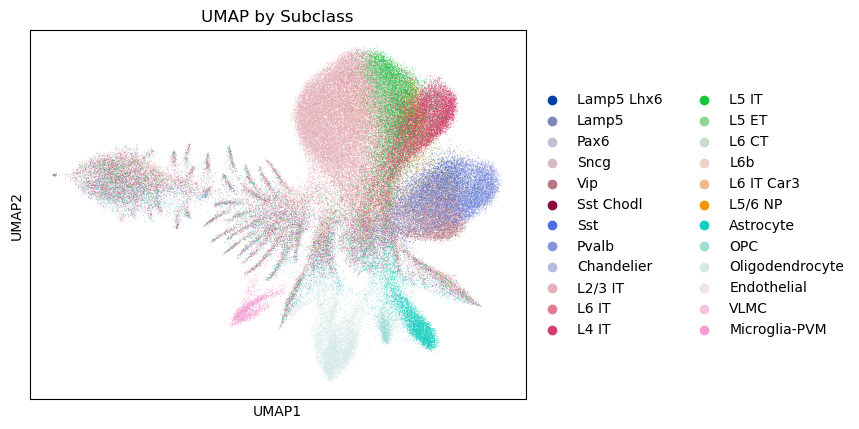

In [8]:
atac = sc.read_h5ad("/mnt/e/Projects/Brain/SEA_AD_analysis/results/aggregated_multiomic/aggregated_genelevel_atac_data.h5ad")  # Peak x Cell matrix
print(atac)
##Save metadata from ATACseq dataset
atac.obs.to_csv("/mnt/e/Projects/Brain/SEA_AD_analysis/results/aggregated_multiomic/aggregated_atac_metadata.csv")

sc.pp.filter_cells(atac, min_genes=200)
sc.pp.filter_genes(atac, min_cells=3)
sc.pp.normalize_total(atac, target_sum=1e4)
sc.pp.log1p(atac)
sc.pp.highly_variable_genes(atac, n_top_genes=2000)
atac = atac[:, atac.var.highly_variable]

sc.pp.pca(atac, n_comps=50, svd_solver='arpack')  # PCA as LSI approximation

# If already LSI-reduced or using other dimensionality reduction, skip the above and just set adata.obsm['X_pca'] accordingly

# Compute neighborhood graph
sc.pp.neighbors(atac, use_rep='X_pca', n_neighbors=15, n_pcs=30)

# Compute UMAP
sc.tl.umap(atac)

# Plot UMAP colored by the 'Subclass' metadata column
sc.pl.umap(atac, color='Subclass', title='UMAP by Subclass')


In [ ]:
rna = sc.read_h5ad("/mnt/e/Projects/Brain/SEA_AD_analysis/results/aggregated_multiomic/aggregated_rna_data.h5ad")  # Peak x Cell matrix
print(rna)
##Save metadata from ATACseq dataset
rna.obs.to_csv("/mnt/e/Projects/Brain/SEA_AD_analysis/results/aggregated_multiomic/aggregated_rna_metadata.csv")

sc.pp.filter_cells(rna, min_genes=200)
sc.pp.filter_genes(rna, min_cells=3)
sc.pp.normalize_total(rna, target_sum=1e4)
sc.pp.log1p(rna)
sc.pp.highly_variable_genes(rna, n_top_genes=2000)
rna = rna[:, rna.var.highly_variable]

sc.pp.pca(rna, n_comps=50, svd_solver='arpack')  # PCA as LSI approximation

# If already LSI-reduced or using other dimensionality reduction, skip the above and just set adata.obsm['X_pca'] accordingly

# Compute neighborhood graph
sc.pp.neighbors(rna, use_rep='X_pca', n_neighbors=15, n_pcs=30)

# Compute UMAP
sc.tl.umap(rna)

# Plot UMAP colored by the 'Subclass' metadata column
sc.pl.umap(rna, color='Subclass', title='UMAP by Subclass')


AnnData object with n_obs × n_vars = 151356 × 36601
    obs: 'sample_id', 'Neurotypical reference', 'Donor ID', 'Organism', 'Brain Region', 'Sex', 'Gender', 'Age at Death', 'Race (choice=White)', 'Race (choice=Black/ African American)', 'Race (choice=Asian)', 'Race (choice=American Indian/ Alaska Native)', 'Race (choice=Native Hawaiian or Pacific Islander)', 'Race (choice=Unknown or unreported)', 'Race (choice=Other)', 'specify other race', 'Hispanic/Latino', 'Highest level of education', 'Years of education', 'PMI', 'Fresh Brain Weight', 'Brain pH', 'Overall AD neuropathological Change', 'Thal', 'Braak', 'CERAD score', 'Overall CAA Score', 'Highest Lewy Body Disease', 'Total Microinfarcts (not observed grossly)', 'Total microinfarcts in screening sections', 'Atherosclerosis', 'Arteriolosclerosis', 'LATE', 'Cognitive Status', 'Last CASI Score', 'Interval from last CASI in months', 'Last MMSE Score', 'Interval from last MMSE in months', 'Last MOCA Score', 'Interval from last MOCA in mon

In [4]:
# Load the original dataset
adata = sc.read_h5ad("/mnt/e/Projects/Brain/SEA_AD_analysis/results/aggregated_multiomic/aggregated_rna_data.h5ad")

# Ensure output directory exists
output_dir = "/mnt/e/Projects/Brain/SEA_AD_analysis/results/aggregated_multiomic/subclass_split_rna"
os.makedirs(output_dir, exist_ok=True)

# Loop over unique subclasses
for subclass in adata.obs["Subclass"].unique():
    # Subset indices for current subclass
    idx = adata.obs["Subclass"] == subclass
    adata_subset = adata[idx].copy()

    # Extract UMI layer to be used as X
    if "UMIs" not in adata_subset.layers:
        raise KeyError("Layer 'UMIs' not found in AnnData object.")

    umi_data = adata_subset.layers["UMIs"]

    # Create new AnnData using UMIs as X, keeping var and obs
    new_adata = ad.AnnData(X=umi_data, obs=adata_subset.obs.copy(), var=adata_subset.var.copy())

    # Optionally, keep the original raw counts in layers too
    new_adata.layers["prenormalized"] = adata_subset.X.copy()

    # Define output filename, sanitizing subclass label
    safe_name = str(subclass).replace(" ", "_").replace("/", "_")
    filename = os.path.join(output_dir, f"subclass_{safe_name}_rna.h5ad")

    # Save to disk
    new_adata.write(filename)

    print(f"Saved {filename}")

Saved /mnt/e/Projects/Brain/SEA_AD_analysis/results/aggregated_multiomic/subclass_split_rna/subclass_L2_3_IT_rna.h5ad
Saved /mnt/e/Projects/Brain/SEA_AD_analysis/results/aggregated_multiomic/subclass_split_rna/subclass_Astrocyte_rna.h5ad
Saved /mnt/e/Projects/Brain/SEA_AD_analysis/results/aggregated_multiomic/subclass_split_rna/subclass_Oligodendrocyte_rna.h5ad
Saved /mnt/e/Projects/Brain/SEA_AD_analysis/results/aggregated_multiomic/subclass_split_rna/subclass_L6_CT_rna.h5ad
Saved /mnt/e/Projects/Brain/SEA_AD_analysis/results/aggregated_multiomic/subclass_split_rna/subclass_Lamp5_rna.h5ad
Saved /mnt/e/Projects/Brain/SEA_AD_analysis/results/aggregated_multiomic/subclass_split_rna/subclass_Vip_rna.h5ad
Saved /mnt/e/Projects/Brain/SEA_AD_analysis/results/aggregated_multiomic/subclass_split_rna/subclass_L4_IT_rna.h5ad
Saved /mnt/e/Projects/Brain/SEA_AD_analysis/results/aggregated_multiomic/subclass_split_rna/subclass_Pvalb_rna.h5ad
Saved /mnt/e/Projects/Brain/SEA_AD_analysis/results/aggreg

In [2]:
# Load the original dataset
adata = sc.read_h5ad("/mnt/e/Projects/Brain/SEA_AD_analysis/results/aggregated_multiomic/aggregated_genelevel_atac_data.h5ad")
print(adata)

# Ensure output directory exists
output_dir = "/mnt/e/Projects/Brain/SEA_AD_analysis/results/aggregated_multiomic/subclass_split_atac"
os.makedirs(output_dir, exist_ok=True)

# Loop over unique subclasses
for subclass in adata.obs["Subclass"].unique():
    # Subset indices for current subclass
    idx = adata.obs["Subclass"] == subclass
    adata_subset = adata[idx].copy()

    # Create new AnnData using UMIs as X, keeping var and obs
    new_adata = ad.AnnData(X=adata_subset.X.copy(), obs=adata_subset.obs.copy(), var=adata_subset.var.copy())

    # Define output filename, sanitizing subclass label
    safe_name = str(subclass).replace(" ", "_").replace("/", "_")
    filename = os.path.join(output_dir, f"subclass_{safe_name}_atac.h5ad")

    # Save to disk
    new_adata.write(filename)

    print(f"Saved {filename}")

KeyboardInterrupt: 

In [57]:
# Adjust paths as needed
rna_dir = Path("/mnt/e/Projects/Brain/SEA_AD_analysis/results/aggregated_multiomic/subclass_split_rna/")
atac_dir = Path("/mnt/e/Projects/Brain/SEA_AD_analysis/results/aggregated_multiomic/subclass_split_atac/")

# ── Primary filtering ────────────────────────────────────────────
min_cells_fraction_rna  = 0.10  # gene expressed in ≥20 % of RNA cells
min_cells_fraction_atac = 0.10  # peak open   in ≥20 % of ATAC cells
variance_threshold      = 1.00  # retain features explaining ≥80 % variance

# ── Cross‑modality requirement ───────────────────────────────────
cross_min_cells_frac = 0.05     # feature must appear in ≥5 % of *other* modality

# Pre‑processing
NORMALIZE_AND_LOG = True        # set False if data already log‑normalized

# Imputation (requires scvi‑tools ≥1.1)
RUN_MULTIVI  = True
MAX_EPOCHS  = 200            # training epochs (adjust for size)




In [58]:
def gene_coverage_frac(adata):
    """Return per‑gene non‑zero fraction (length = n_vars)."""
    if sp.issparse(adata.X):
        nz = np.asarray((adata.X > 0).sum(axis=0)).ravel()
    else:
        nz = np.count_nonzero(adata.X, axis=0)
    return nz / adata.n_obs

In [59]:
def select_primary_genes(adata, min_cells_frac, var_threshold):
    """Genes passing coverage ≥ min_cells_frac and capturing var_threshold variance."""
    cov = gene_coverage_frac(adata)
    keep_cov = cov >= min_cells_frac

    X_keep = adata.X[:, keep_cov]
    genes_keep = adata.var_names[keep_cov]

    if sp.issparse(X_keep):
        X_arr = X_keep.toarray()
    else:
        X_arr = np.asarray(X_keep)

    gene_vars = np.var(X_arr, axis=0)
    order = np.argsort(gene_vars)[::-1]
    cumvar = np.cumsum(gene_vars[order]) / gene_vars.sum() if gene_vars.sum() > 0 else np.ones_like(gene_vars)

    if var_threshold >= 1 or np.isclose(var_threshold, 1.0):
        n_top = len(gene_vars)
    else:
        n_top = np.searchsorted(cumvar, var_threshold) + 1

    selected = set(genes_keep[order[:n_top]])
    return selected, keep_cov.sum(), n_top


In [60]:
def coverage_in(genes, adata):
    """Coverage fraction of *genes present in adata* (list of str)."""
    if not genes:
        return np.array([])
    if sp.issparse(adata.X):
        nz = np.asarray((adata[:, genes].X > 0).sum(axis=0)).ravel()
    else:
        nz = np.count_nonzero(adata[:, genes].X, axis=0)
    return nz / adata.n_obs

In [72]:
# Setup subdirectories
(rna_dir / "filtered").mkdir(parents=True, exist_ok=True)
(rna_dir / "imputed").mkdir(parents=True, exist_ok=True)
(atac_dir / "filtered").mkdir(parents=True, exist_ok=True)
(atac_dir / "imputed").mkdir(parents=True, exist_ok=True)

gene_stats = []
start_total = time.time()

for rna_path in sorted(rna_dir.glob('*_rna.h5ad')):
    cell_type_base = rna_path.stem.replace('_rna','')
    atac_path = atac_dir / f'{cell_type_base}_atac.h5ad'

    if not atac_path.exists():
        print(f'Skip {cell_type_base}: ATAC file missing')
        continue

    print(f'▶ Processing {cell_type_base} …')
    t0 = time.time()
    rna  = sc.read_h5ad(rna_path)
    atac = sc.read_h5ad(atac_path)

    # --- Primary filter ---
    rna_primary, rna_cov_pass, rna_var_keep = select_primary_genes(
        rna,  min_cells_fraction_rna,  variance_threshold)
    atac_primary, atac_cov_pass, atac_var_keep = select_primary_genes(
        atac, min_cells_fraction_atac, variance_threshold)

    print(f'{cell_type_base} RNA : {rna_cov_pass}/{rna.n_vars} pass ≥{min_cells_fraction_rna:.0%} coverage')
    print(f'{cell_type_base} RNA : retaining top {rna_var_keep} (≥{variance_threshold:.0%} var)')
    print(f'{cell_type_base} ATAC: {atac_cov_pass}/{atac.n_vars} pass ≥{min_cells_fraction_atac:.0%} coverage')
    print(f'{cell_type_base} ATAC: retaining top {atac_var_keep} (≥{variance_threshold:.0%} var)')

    # --- Cross‑modality coverage ---
    rna_in_atac  = list(rna_primary  & set(atac.var_names))
    atac_in_rna = list(atac_primary & set(rna.var_names))

    rna_cross_cov  = coverage_in(rna_in_atac,  atac)
    atac_cross_cov = coverage_in(atac_in_rna, rna)

    rna_cov_map  = dict(zip(rna_in_atac,  rna_cross_cov))
    atac_cov_map = dict(zip(atac_in_rna, atac_cross_cov))

    rna_final  = {g for g in rna_primary  if rna_cov_map.get(g, 0)  >= cross_min_cells_frac}
    atac_final = {g for g in atac_primary if atac_cov_map.get(g, 0) >= cross_min_cells_frac}

    print(f'…after cross‑filter (opposite ≥{cross_min_cells_frac:.0%}) → '
          f'{len(rna_final)} RNA genes, {len(atac_final)} ATAC peaks')

    # --- Subset & save ---
    rna_sub  = rna[:,  sorted(rna_final)].copy()
    atac_sub = atac[:, sorted(atac_final)].copy()

    rna_sub.write(rna_dir / "filtered" / f"filtered_{rna_path.name}")
    atac_sub.write(atac_dir / "filtered" / f"filtered_{atac_path.name}")

    # --- Optional imputation ---
    if RUN_MULTIVI:
        # Ensure gene sets match for MultiVI
        #common_genes = rna_sub.var_names.intersection(atac_sub.var_names)
        #if len(common_genes) == 0:
        #    print(f"⚠ No shared genes after filtering — skipping MultiVI for {cell_type_base}")
        #    continue
        
        #rna_sub = rna_sub[:, common_genes].copy()
        #atac_sub = atac_sub[:, common_genes].copy()
    
        # Proceed with MultiVI
        # Rename modalities before passing to MuData
        atac_sub_renamed = atac_sub.copy()
        atac_sub_renamed.var_names = [f"ATAC_{g}" for g in atac_sub_renamed.var_names]
        
        mdata = MuData({"modality1": rna_sub, "modality2": atac_sub_renamed})
        print("Modality keys in MuData:", mdata.mod.keys())
        
        MULTIVI.setup_mudata(
            mdata,
            rna_layer=None,
            atac_layer=None,
            batch_key=None,
            modalities={"modality1": "rna", "modality2": "atac"}
        )

        # ------------------------------------------------------------
        #  Train MultiVI
        # ------------------------------------------------------------
        #n_genes   = rna_sub.n_vars          # after RNA filtering
        #n_regions = atac_sub.n_vars         # after ATAC filtering
        #model = scvi.model.MULTIVI(multi, n_genes=n_genes, n_regions=n_regions)
        
        
        model = MULTIVI(mdata)
        model.train(max_epochs=400)
        
        # MultiVI setup
        #scvi.model.MULTIVI.setup_anndata(multi, batch_key=None, layer=None)
        
        # Initialize + train MultiVI
        #n_genes   = rna_sub.n_vars          # after RNA filtering
        #n_regions = atac_sub.n_vars         # after ATAC filtering
        #model = scvi.model.MULTIVI(multi, n_genes=n_genes, n_regions=n_regions)
        #model.train()
    
        #imputed = model.get_normalized_expression(include_noise=True)
        #rna_sub.layers["imputed"] = imputed.loc[rna_sub.obs_names, :].values
        #atac_sub.layers["imputed"] = model.get_accessibility_estimates().loc[atac_sub.obs_names, :].values
        # Save imputed results
        #rna_sub.layers["imputed"] = model.get_normalized_expression().loc[rna_sub.obs_names].values
        #atac_sub.layers["imputed"] = model.get_accessibility_estimates().loc[atac_sub.obs_names].values
        rna_sub.layers["imputed"]  = model.get_normalized_expression().loc[rna_sub.obs_names].values
        atac_sub.layers["imputed"] = model.get_accessibility_estimates().loc[atac_sub.obs_names].values
    
        # Save
        rna_sub.write(rna_dir / "imputed" / f"imputed_{rna_path.name}")
        atac_sub.write(atac_dir / "imputed" / f"imputed_{atac_path.name}")

    # --- Stats ---
    gene_stats.append({
        'cell_type'          : cell_type_base,
        'RNA_primary'        : len(rna_primary),
        'ATAC_primary'       : len(atac_primary),
        'RNA_final'          : len(rna_final),
        'ATAC_final'         : len(atac_final),
        'intersection_final' : len(rna_final & atac_final),
        'union_final'        : len(rna_final | atac_final),
        'time_s'             : round(time.time() - t0, 1),
    })
    print(f'  ✓ completed in {gene_stats[-1]["time_s"]} s\n')

print(f'All done in {round(time.time()-start_total,1)} s.')

▶ Processing subclass_Astrocyte …
subclass_Astrocyte RNA : 9404/36601 pass ≥10% coverage
subclass_Astrocyte RNA : retaining top 9404 (≥100% var)
subclass_Astrocyte ATAC: 12072/41092 pass ≥10% coverage
subclass_Astrocyte ATAC: retaining top 12072 (≥100% var)
…after cross‑filter (opposite ≥5%) → 7003 RNA genes, 7911 ATAC peaks
Modality keys in MuData: dict_keys(['modality1', 'modality2'])


/home/xetrin/miniconda3/envs/rna_atac_env/lib/python3.10/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/home/xetrin/miniconda3/envs/rna_atac_env/lib/python3.10/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)


ValueError: Extraneous modality mapping(s) detected: {'modality1', 'modality2'}

In [4]:
rna_dir = Path("/mnt/e/Projects/Brain/SEA_AD_analysis/results/aggregated_multiomic/subclass_split_rna/")
atac_dir = Path("/mnt/e/Projects/Brain/SEA_AD_analysis/results/aggregated_multiomic/subclass_split_atac/")

min_cells_fraction_rna = 0.1            # example: 10% min nonzero
min_cells_fraction_atac = 0.1
variance_threshold = 1.0                # keep all (set <1 to keep top X% by var)
cross_min_cells_frac = 0.05

# Create output directories if not exist
for d in [rna_dir / "filtered", rna_dir / "imputed", atac_dir / "filtered", atac_dir / "imputed"]:
    d.mkdir(parents=True, exist_ok=True)

gene_stats = []
start_total = time.time()

def select_primary_genes(adata, min_cells_frac, var_thresh):
    n_cells = adata.shape[0]
    coverage = (adata.X > 0).sum(axis=0) / n_cells
    if hasattr(coverage, 'A1'): coverage = coverage.A1  # for sparse
    coverage = np.array(coverage).ravel()
    var = np.var(adata.X.toarray() if hasattr(adata.X, 'toarray') else adata.X, axis=0)
    genes = np.array(adata.var_names)
    cov_pass = genes[coverage >= min_cells_frac]
    sorted_var = np.argsort(-var)
    var_keep = int(len(var) * var_thresh)
    var_pass = genes[sorted_var[:var_keep]]
    selected = set(cov_pass).intersection(var_pass)
    return selected, (coverage >= min_cells_frac).sum(), var_keep

def coverage_in(genes, adata):
    idx = [adata.var_names.get_loc(g) for g in genes if g in adata.var_names]
    arr = adata.X[:, idx]
    if hasattr(arr, "toarray"):
        arr = arr.toarray()
    return (arr > 0).sum(axis=0) / adata.n_obs

for rna_path in sorted(rna_dir.glob('*_rna.h5ad')):
    cell_type_base = rna_path.stem.replace('_rna','')
    atac_path = atac_dir / f'{cell_type_base}_atac.h5ad'

    if not atac_path.exists():
        print(f'Skip {cell_type_base}: ATAC file missing')
        continue

    print(f'▶ Processing {cell_type_base} …')
    t0 = time.time()
    rna  = sc.read_h5ad(rna_path)
    atac = sc.read_h5ad(atac_path)
    # --- Normalize and log1p RNA and ATAC ---
    # Normalization
    sc.pp.normalize_total(rna, target_sum=1e4)
    sc.pp.log1p(rna)
    sc.pp.normalize_total(atac, target_sum=1e4)
    sc.pp.log1p(atac)

    # --- Primary filter ---
    rna_primary, rna_cov_pass, rna_var_keep = select_primary_genes(rna,  min_cells_fraction_rna,  variance_threshold)
    atac_primary, atac_cov_pass, atac_var_keep = select_primary_genes(atac, min_cells_fraction_atac, variance_threshold)

    print(f'{cell_type_base} RNA : {rna_cov_pass}/{rna.n_vars} pass ≥{min_cells_fraction_rna:.0%} coverage')
    print(f'{cell_type_base} RNA : retaining top {rna_var_keep} (≥{variance_threshold:.0%} var)')
    print(f'{cell_type_base} ATAC: {atac_cov_pass}/{atac.n_vars} pass ≥{min_cells_fraction_atac:.0%} coverage')
    print(f'{cell_type_base} ATAC: retaining top {atac_var_keep} (≥{variance_threshold:.0%} var)')

    # --- Cross‑modality coverage ---
    rna_in_atac  = list(rna_primary  & set(atac.var_names))
    atac_in_rna = list(atac_primary & set(rna.var_names))

    rna_cross_cov  = coverage_in(rna_in_atac,  atac)
    atac_cross_cov = coverage_in(atac_in_rna, rna)

    rna_cov_map  = dict(zip(rna_in_atac,  rna_cross_cov))
    atac_cov_map = dict(zip(atac_in_rna, atac_cross_cov))

    rna_final  = {g for g in rna_primary  if rna_cov_map.get(g, 0)  >= cross_min_cells_frac}
    atac_final = {g for g in atac_primary if atac_cov_map.get(g, 0) >= cross_min_cells_frac}

    print(f'…after cross‑filter (opposite ≥{cross_min_cells_frac:.0%}) → '
          f'{len(rna_final)} RNA genes, {len(atac_final)} ATAC peaks')

    # --- Subset filtered data ---
    rna_sub  = rna[:,  sorted(rna_final)].copy()
    atac_sub = atac[:, sorted(atac_final)].copy()

    # --- Save filtered, normalized data ---
    rna_sub.write(rna_dir / "filtered" / f"filtered_{rna_path.name}")
    atac_sub.write(atac_dir / "filtered" / f"filtered_{atac_path.name}")

    # Align cells and merge
    common_cells = rna_sub.obs_names.intersection(atac_sub.obs_names)
    rna_sub  = rna[common_cells,  sorted(rna_final)].copy()
    atac_sub = atac[common_cells, sorted(atac_final)].copy()

    # --- Merge for joint imputation ---
    df_rna = pd.DataFrame(rna_sub.X.toarray() if hasattr(rna_sub.X, "toarray") else rna_sub.X,
                          index=rna_sub.obs_names, columns=[f"RNA_{g}" for g in rna_sub.var_names])
    df_atac = pd.DataFrame(atac_sub.X.toarray() if hasattr(atac_sub.X, "toarray") else atac_sub.X,
                           index=atac_sub.obs_names, columns=[f"ATAC_{g}" for g in atac_sub.var_names])

    merged_df = pd.concat([df_rna, df_atac], axis=1)
    
    # Prepare the data (merge RNA and ATAC, as you did for SoftImpute)
    # Fill missing (nan) with zeros for now, but mask them in loss
    X = merged_df.values.astype(np.float32)
    nan_mask = np.isnan(X)
    X_filled = np.nan_to_num(X, nan=0.0)
    
    X_tensor = torch.tensor(X_filled, device=device)
    mask_tensor = torch.tensor(~nan_mask, device=device, dtype=torch.float32)
    
    # Define simple autoencoder
    class Autoencoder(nn.Module):
        def __init__(self, n_in, n_hidden=256):
            super().__init__()
            self.encoder = nn.Sequential(
                nn.Linear(n_in, n_hidden),
                nn.ReLU(),
                nn.Linear(n_hidden, n_hidden//2),
                nn.ReLU()
            )
            self.decoder = nn.Sequential(
                nn.Linear(n_hidden//2, n_hidden),
                nn.ReLU(),
                nn.Linear(n_hidden, n_in)
            )
        def forward(self, x):
            return self.decoder(self.encoder(x))
    
    model = Autoencoder(X.shape[1]).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
    # Training loop
    n_epochs = 100
    for epoch in range(n_epochs):
        model.train()
        optimizer.zero_grad()
        X_pred = model(X_tensor)
        # Only compute loss for *observed* values!
        loss = (((X_pred - X_tensor) * mask_tensor)**2).sum() / mask_tensor.sum()
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0 or epoch == n_epochs - 1:
            print(f"Epoch {epoch+1}/{n_epochs} - Loss: {loss.item():.4f}")
    
    # Imputed values (replace only where nan in original)
    X_imputed = X_tensor.clone()
    X_pred = model(X_tensor).detach().cpu().numpy()
    X_imputed = X.copy()
    X_imputed[nan_mask] = X_pred[nan_mask]
    
    # Build pandas DataFrame
    imputed_df = pd.DataFrame(X_imputed, index=merged_df.index, columns=merged_df.columns)

    # --- Split back into RNA and ATAC, store in AnnData layers ---
    rna_cols = [c for c in imputed_df.columns if c.startswith("RNA_")]
    atac_cols = [c for c in imputed_df.columns if c.startswith("ATAC_")]

    imputed_rna = imputed_df[rna_cols]
    imputed_rna.columns = [c.replace("RNA_", "") for c in imputed_rna.columns]
    imputed_atac = imputed_df[atac_cols]
    imputed_atac.columns = [c.replace("ATAC_", "") for c in imputed_atac.columns]

    # Reorder to match AnnData var_names (should be identical but just in case)
    imputed_rna = imputed_rna[rna_sub.var_names]
    imputed_atac = imputed_atac[atac_sub.var_names]

    rna_sub.layers["imputed"] = imputed_rna.values
    atac_sub.layers["imputed"] = imputed_atac.values
    rna_sub.write(rna_dir / "imputed" / f"imputed_{rna_path.name}")
    atac_sub.write(atac_dir / "imputed" / f"imputed_{atac_path.name}")

    # --- Stats ---
    gene_stats.append({
        'cell_type'          : cell_type_base,
        'RNA_primary'        : len(rna_primary),
        'ATAC_primary'       : len(atac_primary),
        'RNA_final'          : len(rna_final),
        'ATAC_final'         : len(atac_final),
        'intersection_final' : len(rna_final & atac_final),
        'union_final'        : len(rna_final | atac_final),
        'time_s'             : round(time.time() - t0, 1),
    })
    print(f'  ✓ completed in {gene_stats[-1]["time_s"]} s\n')

print(f'All done in {round(time.time()-start_total,1)} s.')

▶ Processing subclass_Astrocyte …
subclass_Astrocyte RNA : 9404/36601 pass ≥10% coverage
subclass_Astrocyte RNA : retaining top 36601 (≥100% var)
subclass_Astrocyte ATAC: 12072/41092 pass ≥10% coverage
subclass_Astrocyte ATAC: retaining top 41092 (≥100% var)
…after cross‑filter (opposite ≥5%) → 7003 RNA genes, 7911 ATAC peaks
Epoch 1/100 - Loss: 0.4771
Epoch 11/100 - Loss: 0.2839
Epoch 21/100 - Loss: 0.2400
Epoch 31/100 - Loss: 0.2270
Epoch 41/100 - Loss: 0.2227
Epoch 51/100 - Loss: 0.2206
Epoch 61/100 - Loss: 0.2176
Epoch 71/100 - Loss: 0.2135
Epoch 81/100 - Loss: 0.2119
Epoch 91/100 - Loss: 0.2112
Epoch 100/100 - Loss: 0.2108
  ✓ completed in 27.3 s

▶ Processing subclass_Chandelier …
subclass_Chandelier RNA : 10196/36601 pass ≥10% coverage
subclass_Chandelier RNA : retaining top 36601 (≥100% var)
subclass_Chandelier ATAC: 13485/41092 pass ≥10% coverage
subclass_Chandelier ATAC: retaining top 41092 (≥100% var)
…after cross‑filter (opposite ≥5%) → 7781 RNA genes, 8622 ATAC peaks
Epoch

KeyboardInterrupt: 

In [6]:
test1 = sc.read_h5ad("/mnt/e/Projects/Brain/SEA_AD_analysis/results/aggregated_multiomic/subclass_split_rna/filtered/filtered_subclass_Astrocyte_rna.h5ad")
test2 = sc.read_h5ad("/mnt/e/Projects/Brain/SEA_AD_analysis/results/aggregated_multiomic/subclass_split_rna/imputed/imputed_subclass_Astrocyte_rna.h5ad")
test3 = sc.read_h5ad("/mnt/e/Projects/Brain/SEA_AD_analysis/results/aggregated_multiomic/subclass_split_rna/subclass_Astrocyte_rna.h5ad")
print(test1)
print(test1.X[1:15,1:5])
print(test2)
print(test2.X[1:15,1:5])
print(test3)
print(test3.X[1:15,1:5])


AnnData object with n_obs × n_vars = 7762 × 7003
    obs: 'sample_id', 'Neurotypical reference', 'Donor ID', 'Organism', 'Brain Region', 'Sex', 'Gender', 'Age at Death', 'Race (choice=White)', 'Race (choice=Black/ African American)', 'Race (choice=Asian)', 'Race (choice=American Indian/ Alaska Native)', 'Race (choice=Native Hawaiian or Pacific Islander)', 'Race (choice=Unknown or unreported)', 'Race (choice=Other)', 'specify other race', 'Hispanic/Latino', 'Highest level of education', 'Years of education', 'PMI', 'Fresh Brain Weight', 'Brain pH', 'Overall AD neuropathological Change', 'Thal', 'Braak', 'CERAD score', 'Overall CAA Score', 'Highest Lewy Body Disease', 'Total Microinfarcts (not observed grossly)', 'Total microinfarcts in screening sections', 'Atherosclerosis', 'Arteriolosclerosis', 'LATE', 'Cognitive Status', 'Last CASI Score', 'Interval from last CASI in months', 'Last MMSE Score', 'Interval from last MMSE in months', 'Last MOCA Score', 'Interval from last MOCA in months


▶ Processing subclass_Astrocyte …
subclass_Astrocyte RNA: 36601/36601 genes pass ≥0% coverage
subclass_Astrocyte RNA: retaining **all** 36601 genes (var_threshold = 1.0)
subclass_Astrocyte ATAC: 41092/41092 genes pass ≥0% coverage
subclass_Astrocyte ATAC: retaining **all** 41092 genes (var_threshold = 1.0)
   RNA genes:  36601 | ATAC genes: 41092
   UNION:      54476 | INTERSECTION: 23217

▶ Processing subclass_Chandelier …
subclass_Chandelier RNA: 36601/36601 genes pass ≥0% coverage
subclass_Chandelier RNA: retaining **all** 36601 genes (var_threshold = 1.0)
subclass_Chandelier ATAC: 41092/41092 genes pass ≥0% coverage
subclass_Chandelier ATAC: retaining **all** 41092 genes (var_threshold = 1.0)
   RNA genes:  36601 | ATAC genes: 41092
   UNION:      54476 | INTERSECTION: 23217

▶ Processing subclass_Endothelial …
subclass_Endothelial RNA: 36601/36601 genes pass ≥0% coverage
subclass_Endothelial RNA: retaining **all** 36601 genes (var_threshold = 1.0)
subclass_Endothelial ATAC: 41092

KeyboardInterrupt: 

In [ ]:
atac_list = []

for donor_id in metadata["donor_id"].unique():
    donor_samples = metadata.query("donor_id == @donor_id")["sample_id"].unique()

    # Find matching ATAC file
    atac_file = next(atac_data_dir.glob(f"*{donor_id}*.h5ad"), None)
    if not atac_file:
        print(f"No ATAC file found for donor {donor_id}")
        continue

    print(f"Loading ATAC for donor {donor_id}")
    adata = sc.read_h5ad(atac_file)

    # Subset to relevant samples
    if "sample_id" in adata.obs.columns:
        adata = adata[adata.obs["sample_id"].isin(donor_samples)].copy()
    else:
        print(f"No 'sample_id' column in ATAC obs for donor {donor_id}, skipping.")
        continue

    # Add donor label
    adata.obs["donor_id"] = donor_id

    atac_list.append(adata)
    del adata  # free memory

# Concatenate all donor ATAC
aggregated_atac = sc.concat(atac_list, join="outer", index_unique=None)
aggregated_atac.write(atac_outfile, compression=None)
del atac_list, aggregated_atac
